# Manufacturing process of an electric motor (use case)

In this notebook, we present the implementation of the manufacturing process of an electric motor use cases.

## Preliminaries

### Available services

We start with the definitions of the available services.

In [1]:
# Python imports, put at the top for simplicity
from logaut import ltl2dfa
from pylogics.parsers import parse_ltl

from docs.notebooks.utils import render_composition_mdp
from docs.notebooks.utils import render_mdp_dfa
from docs.notebooks.utils import render_service
from aida.constants import OTHER_ACTION_SYMBOL
from aida.declare_utils import *
from aida.dfa_target import from_symbolic_automaton_to_declare_automaton
from aida.dfa_target import mdp_from_dfa
from aida.lmdp import compute_composition_lmdp
from aida.lvi import lexicographic_value_iteration
from aida.services import build_service_from_transitions, Service


In [2]:
HIGH_PROB = 0.95
LOW_PROB = 0.05

# probabilities of being broken after an action
DEFAULT_BROKEN_PROB = LOW_PROB # 0.05

# default probability of being unemployable after the configuration
DEFAULT_UNEMPLOYABLE_PROB = LOW_PROB # 0.05

# default discount factor
GAMMA = 0.9
GAMMAS = [1.0, GAMMA, GAMMA]

VERY_HIGH_REWARD = 5.0
HIGH_REWARD = 2.5
LOW_REWARD = 1.0
VERY_LOW_REWARD = 0.5
VERY_LOW_COST = -VERY_LOW_REWARD # -0.5
LOW_COST = -LOW_REWARD # -1.0
HIGH_COST = -HIGH_REWARD # -2.5
VERY_HIGH_COST = -VERY_HIGH_REWARD # -5.0

# default economic cost value
DEFAULT_ECONOMIC_REWARD = LOW_COST # -1.0

# default quality reward value
DEFAULT_QUALITY_REWARD = LOW_REWARD # 1.0

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = HIGH_COST # -2.5

# default reward to repair the device
DEFAULT_REPAIR_REWARD = LOW_COST # -1.0


In [3]:
# all the atomic actions for the task
BUILD_RETRIEVE_STATOR = "build_retrieve_stator"
BUILD_RETRIEVE_ROTOR = "build_retrieve_rotor"
BUILD_RETRIEVE_INVERTER = "build_retrieve_inverter"
ASSEMBLE_MOTOR = "assemble_motor"
PAINTING = "painting"
RUNNING_IN = "running_in"
ELECTRIC_TEST = "electric_test"
STATIC_TEST = "static_test"

ALL_SYMBOLS = {
    BUILD_RETRIEVE_STATOR,
    BUILD_RETRIEVE_ROTOR,
    BUILD_RETRIEVE_INVERTER,
    ASSEMBLE_MOTOR,
    PAINTING,
    RUNNING_IN,
    ELECTRIC_TEST,
    STATIC_TEST,
}

In [4]:
# service names
STATOR_BUILDER_SERVICE_NAME = "stator_builder"                  # machine
STATOR_WAREHOUSE_SERVICE_NAME = "stator_warehouse"              # warehouse
ROTOR_BUILDER_1_SERVICE_NAME = "rotor_builder_1"                # machine
ROTOR_BUILDER_2_SERVICE_NAME = "rotor_builder_2"                # machine
ROTOR_WAREHOUSE_SERVICE_NAME = "rotor_warehouse"                # warehouse
INVERTER_WAREHOUSE_SERVICE_NAME = "inverter_warehouse"          # warehouse
ASSEMBLER_1_MACHINE_SERVICE_NAME = "assembler_1_machine"        # machine
ASSEMBLER_2_HUMAN_SERVICE_NAME = "assembler_2_human"            # human
PAINTER_1_MACHINE_SERVICE_NAME = "painter_1_machine"            # machine
PAINTER_2_HUMAN_SERVICE_NAME = "painter_2_human"                # human
SMART_TESTER_1_MACHINE_SERVICE_NAME = "smart_tester_1_machine"  # machine
SMART_TESTER_2_HUMAN_SERVICE_NAME = "smart_tester_2_human"      # human
MECHANICAL_ENGINEER_SERVICE_NAME = "mechanical_engineer"        # human

We have three type of services:
- breakable machines
- warehouse machines
- human workers


In [5]:
from typing import Set


def build_generic_breakable_service(
    service_name: str,
    operation_name: str,
    economic_reward_op: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward_good: float = DEFAULT_QUALITY_REWARD,
    quality_reward_bad: float = DEFAULT_QUALITY_REWARD,
    repair_reward: float = DEFAULT_REPAIR_REWARD,
    broken_prob: float = DEFAULT_BROKEN_PROB,
    unemployable_prob: float = DEFAULT_UNEMPLOYABLE_PROB,
) -> Service:
    """Build the stator builder device."""
    assert 0.0 <= broken_prob <= 1.0
    deterministic_prob = 1.0
    op_success_prob = 1.0 - broken_prob
    configure_success_prob = 1.0 - unemployable_prob

    # compute average quality reward
    average_quality_reward_op_action =  quality_reward_good * (1 - broken_prob) + quality_reward_bad * broken_prob

    transitions = {
        "ready": { # current state
            f"CONFIG[{service_name}]": # action
                (
                    {
                        "configured": deterministic_prob # next state : prob
                    },
                    (0.0, 0.0) # cost and quality reward 
                ),
        },
        "configured": {
            f"CHECKED[{service_name}]":
                (
                    {
                    "executing": configure_success_prob,
                    "broken": unemployable_prob
                    } if unemployable_prob > 0.0 else {"executing": op_success_prob},
                    (0.0, 0.0)
                ),
        },
        "executing": {
            operation_name: # operation
                (
                    {
                        "ready": op_success_prob,
                        "broken": broken_prob
                    } if broken_prob > 0.0 else {"ready": op_success_prob},
                    (economic_reward_op, average_quality_reward_op_action)
                ),
        },
        "broken": {
            f"RESTORE[{service_name}]":
               (
                   {
                       "repairing": deterministic_prob
                   },
                   (repair_reward, 0.0)
               ),
        },
        "repairing": {
            f"REPAIRED[{service_name}]":
                (
                    {
                        "ready": deterministic_prob
                    },
                    (0.0, 0.0)
                ),
        },

    }

    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore


def build_generic_service_one_state(
    service_name: str,
    operation_names: Set[str],
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the stator warehouse device."""
    transitions = {
        "ready": {
            operation_name: ({"ready": 1.0}, (economic_reward, quality_reward)) for operation_name in operation_names
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore


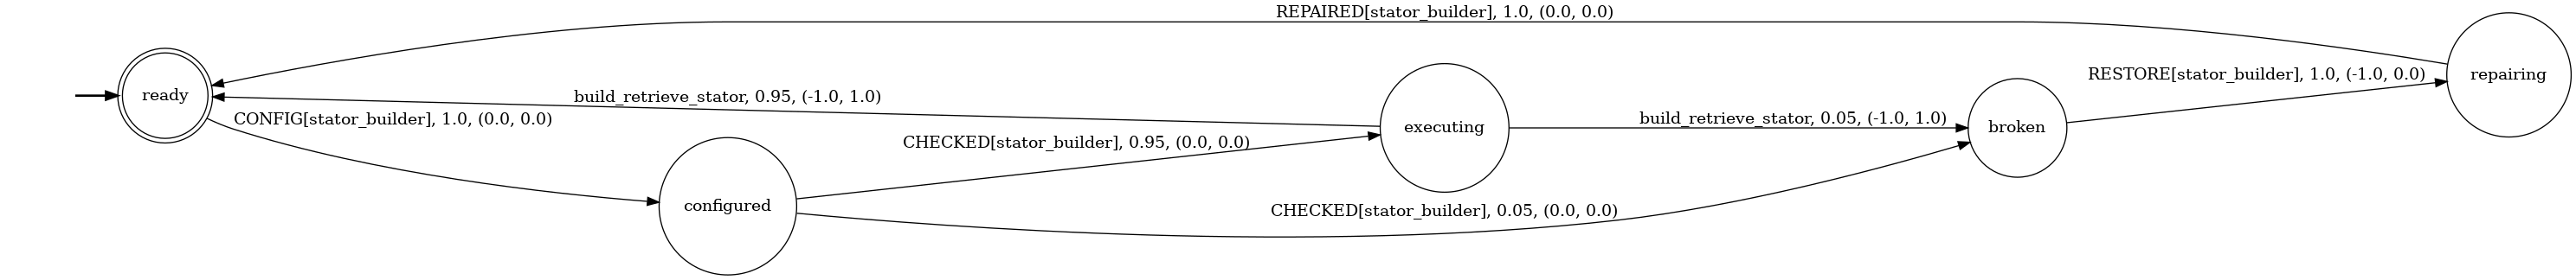

In [6]:
def stator_builder_service(
    name: str = STATOR_BUILDER_SERVICE_NAME,
    economic_reward_op: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward_good: float = DEFAULT_QUALITY_REWARD,
    quality_reward_bad: float = DEFAULT_QUALITY_REWARD,
    repair_reward: float = DEFAULT_REPAIR_REWARD,
    broken_prob: float = DEFAULT_BROKEN_PROB,
    unemployable_prob: float = DEFAULT_UNEMPLOYABLE_PROB,
) -> Service:
    """Build the stator builder device."""
    return build_generic_breakable_service(
        name,
        BUILD_RETRIEVE_STATOR,
        economic_reward_op=economic_reward_op,
        quality_reward_good=quality_reward_good,
        quality_reward_bad=quality_reward_bad,
        repair_reward=repair_reward,
        broken_prob=broken_prob,
        unemployable_prob=unemployable_prob,
    )

service_stator_builder = stator_builder_service()
render_service(service_stator_builder)

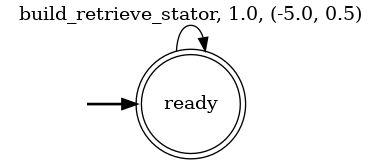

In [7]:
def stator_warehouse_service(
    name: str,
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the stator warehouse device."""
    return build_generic_service_one_state(
        name,
        {BUILD_RETRIEVE_STATOR},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )

service_stator_warehouse = stator_warehouse_service(STATOR_WAREHOUSE_SERVICE_NAME, economic_reward=VERY_HIGH_COST, quality_reward=VERY_LOW_REWARD)
render_service(service_stator_warehouse)


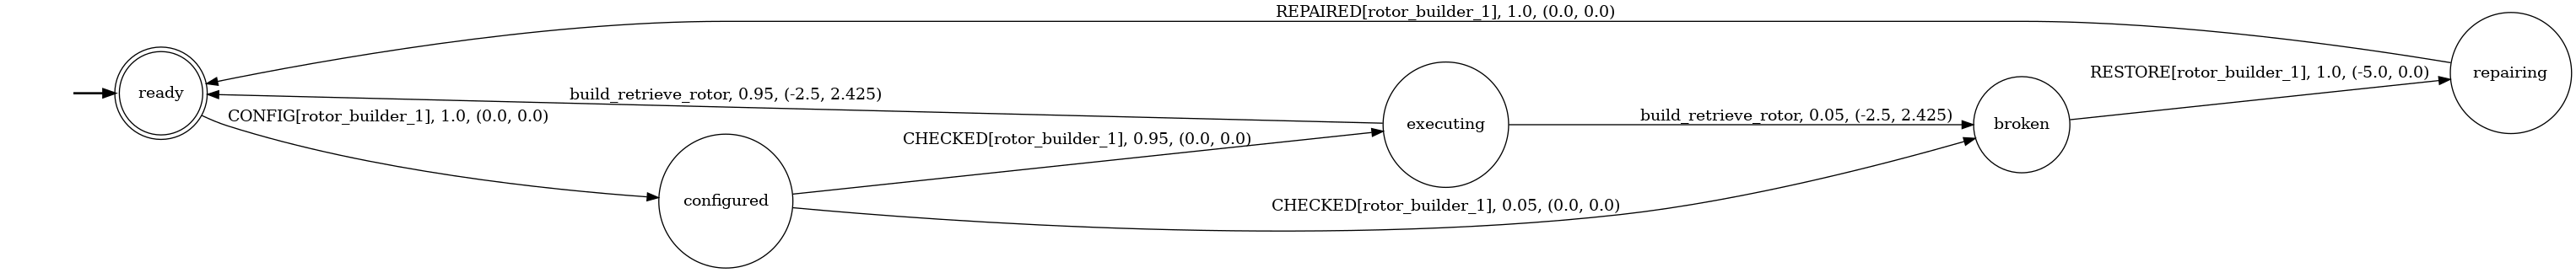

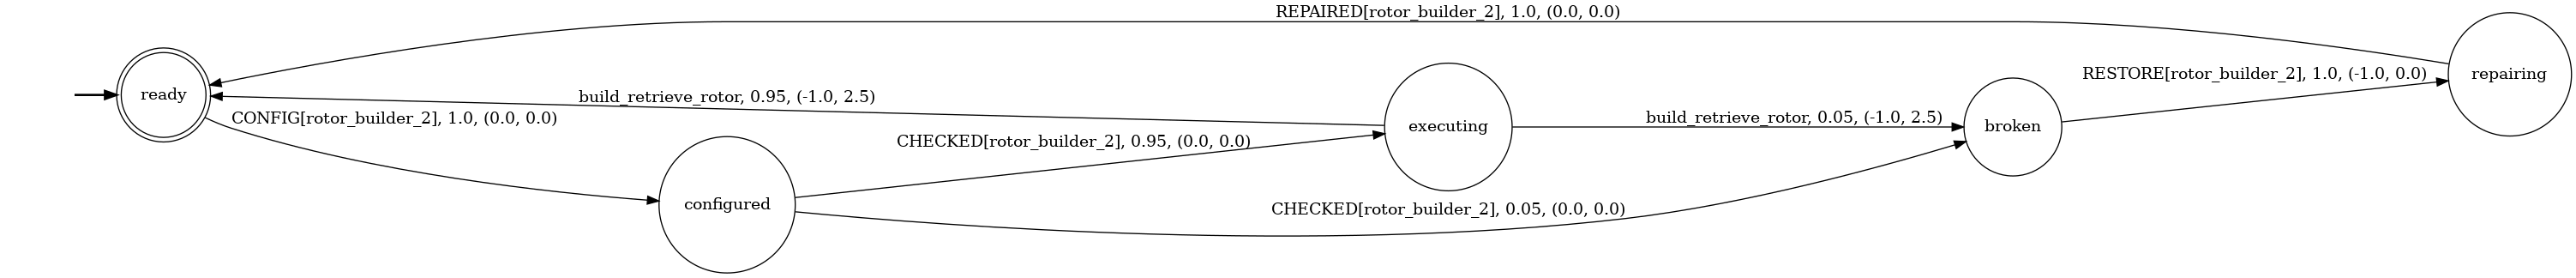

In [8]:
def rotor_builder_service(
    name: str,
    economic_reward_op: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward_good: float = DEFAULT_QUALITY_REWARD,
    quality_reward_bad: float = DEFAULT_QUALITY_REWARD,
    repair_reward: float = DEFAULT_REPAIR_REWARD,
    broken_prob: float = DEFAULT_BROKEN_PROB,
    unemployable_prob: float = DEFAULT_UNEMPLOYABLE_PROB,
) -> Service:
    """Build the rotor builder device."""
    return build_generic_breakable_service(
        name,
        BUILD_RETRIEVE_ROTOR,
        economic_reward_op=economic_reward_op,
        quality_reward_good=quality_reward_good,
        quality_reward_bad=quality_reward_bad,
        repair_reward=repair_reward,
        broken_prob=broken_prob,
        unemployable_prob=unemployable_prob,
    )

# high economic cost - high quality reward
service_rotor_builder_1 = rotor_builder_service(
    ROTOR_BUILDER_1_SERVICE_NAME,
    economic_reward_op=HIGH_COST,
    quality_reward_good=HIGH_REWARD,
    quality_reward_bad=LOW_REWARD,
    repair_reward=VERY_HIGH_COST,
    broken_prob=DEFAULT_BROKEN_PROB,
    unemployable_prob=DEFAULT_UNEMPLOYABLE_PROB,
)
# low economic cost - high quality reward
service_rotor_builder_2 = rotor_builder_service(
    ROTOR_BUILDER_2_SERVICE_NAME,
    economic_reward_op=LOW_COST,
    quality_reward_good=HIGH_REWARD,
    quality_reward_bad=HIGH_REWARD,
    repair_reward=LOW_COST,
    broken_prob=DEFAULT_BROKEN_PROB,
    unemployable_prob=DEFAULT_UNEMPLOYABLE_PROB,
)

render_service(service_rotor_builder_1)
render_service(service_rotor_builder_2)

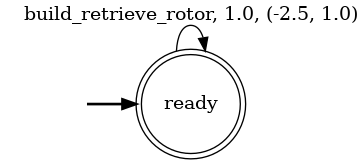

In [9]:
def rotor_warehouse_service(
    name: str,
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the rotor warehouse device."""
    return build_generic_service_one_state(
        name,
        {BUILD_RETRIEVE_ROTOR},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )

service_rotor_warehouse = rotor_warehouse_service(ROTOR_WAREHOUSE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=LOW_REWARD)
render_service(service_rotor_warehouse)

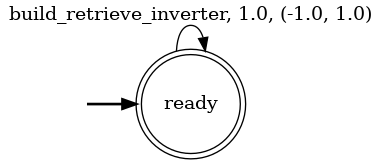

In [10]:
def inverter_warehouse_service(
    name: str,
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the inverter warehouse device."""
    """Build the stator warehouse device."""
    return build_generic_service_one_state(
        name,
        {BUILD_RETRIEVE_INVERTER},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )
service_inverter_warehouse = inverter_warehouse_service(INVERTER_WAREHOUSE_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD)
render_service(service_inverter_warehouse)

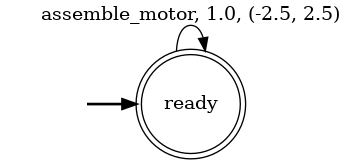

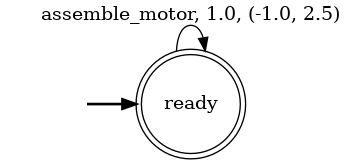

In [11]:
def assembler_service(
    name: str,
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the assembler device."""
    return build_generic_service_one_state(
        name,
        {ASSEMBLE_MOTOR},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )

# high economic cost - high quality reward
service_assembler_1 = assembler_service(ASSEMBLER_1_MACHINE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=HIGH_REWARD)
# low economic cost - low quality reward
service_assembler_2 = assembler_service(ASSEMBLER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=HIGH_REWARD)
render_service(service_assembler_1)
render_service(service_assembler_2)

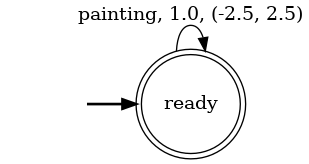

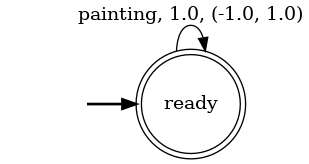

In [12]:
def painter_service(
    name: str,
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the painter device."""
    return build_generic_service_one_state(
        name,
        {PAINTING},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )


# high economic cost - high quality reward
service_painter_1 = painter_service(PAINTER_1_MACHINE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=HIGH_REWARD)
# low economic cost - low quality reward
service_painter_2 = painter_service(PAINTER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD)

render_service(service_painter_1)
render_service(service_painter_2)

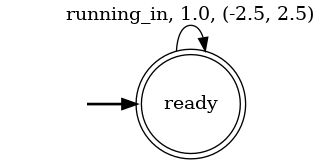

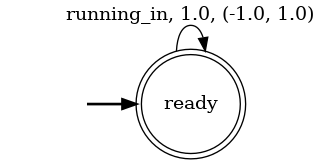

In [13]:
def smart_tester_service(
    name: str,
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the smart tester device."""
    return build_generic_service_one_state(
        name,
        {RUNNING_IN},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )

# high economic cost - high quality reward
service_smart_tester_1 = smart_tester_service(SMART_TESTER_1_MACHINE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=HIGH_REWARD)
# low economic cost - low quality reward
service_smart_tester_2 = smart_tester_service(SMART_TESTER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD)

render_service(service_smart_tester_1)
render_service(service_smart_tester_2)

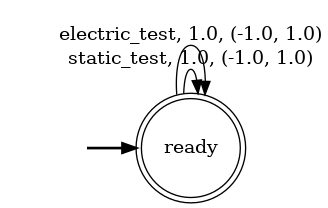

In [14]:
def mechanical_engineer_service(
    name: str,
    economic_reward: float = DEFAULT_ECONOMIC_REWARD,
    quality_reward: float = DEFAULT_QUALITY_REWARD
) -> Service:
    """Build the mechanical engineer device."""
    return build_generic_service_one_state(
        name,
        {ELECTRIC_TEST, STATIC_TEST},
        economic_reward=economic_reward,
        quality_reward=quality_reward
    )

service_mechanical_engineer = mechanical_engineer_service(MECHANICAL_ENGINEER_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD)
render_service(service_mechanical_engineer)

### Target specification
In this section, we list all the DECLARE constraints, transform each of them in LTLf formulas (according to the paper) and put them in conjunction in order to compute the equivalent automaton.

Then, we also show the MDP representation of the DFA.

(and (eventually build_retrieve_stator) (always (implies build_retrieve_stator (weak_next (always (not build_retrieve_stator))))) (eventually build_retrieve_rotor) (always (implies build_retrieve_rotor (weak_next (always (not build_retrieve_rotor))))) (eventually build_retrieve_inverter) (always (implies build_retrieve_inverter (weak_next (always (not build_retrieve_inverter))))) (eventually running_in) (always (implies running_in (weak_next (always (not running_in))))) (eventually assemble_motor) (always (implies assemble_motor (weak_next (always (not assemble_motor))))) (always (implies electric_test (weak_next (always (not electric_test))))) (always (implies painting (weak_next (always (not painting))))) (always (implies static_test (weak_next (always (not static_test))))) (always (implies build_retrieve_stator (next (until (not build_retrieve_stator) assemble_motor)))) (or (always (not assemble_motor)) (until (not assemble_motor) build_retrieve_stator)) (always (implies assemble_mo

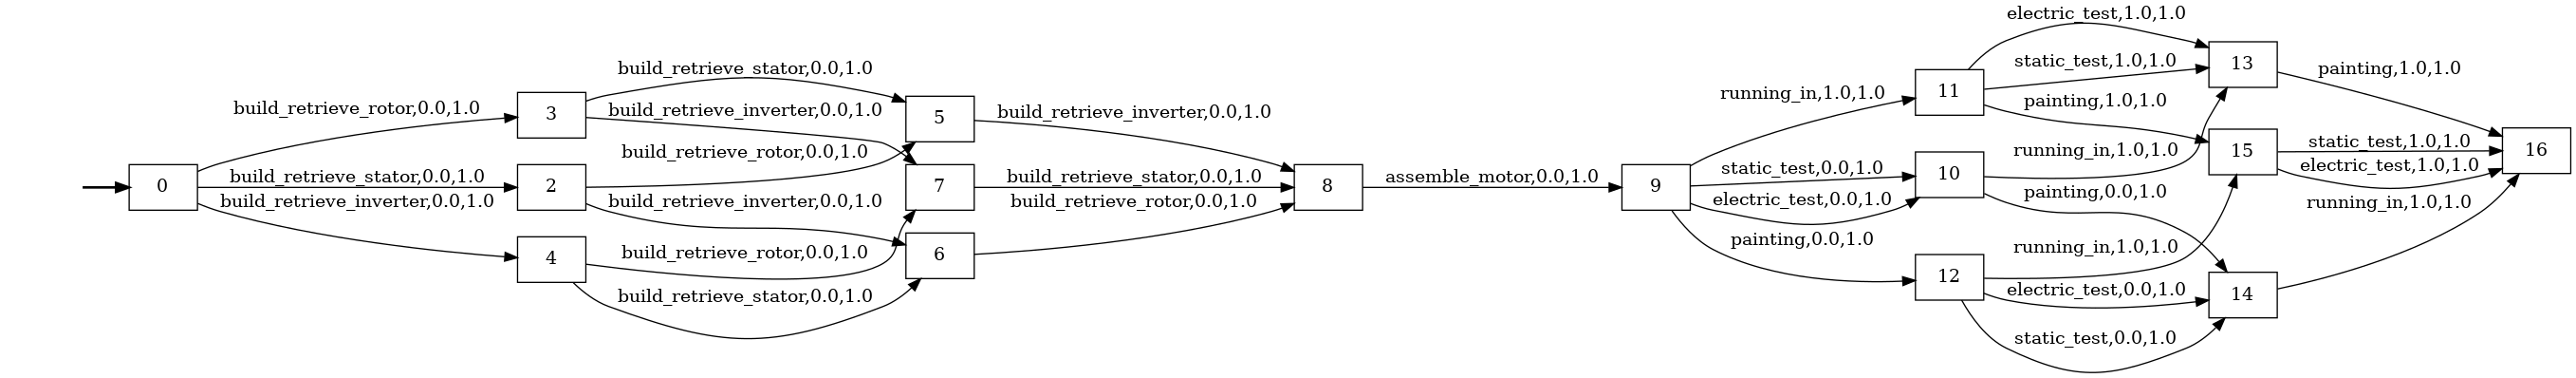

In [16]:

from docs.notebooks.utils import render_digraph

declare_constraints = [
    exactly_once(BUILD_RETRIEVE_STATOR),
    exactly_once(BUILD_RETRIEVE_ROTOR),
    exactly_once(BUILD_RETRIEVE_INVERTER),
    exactly_once(RUNNING_IN),
    exactly_once(ASSEMBLE_MOTOR),
    absence_2(ELECTRIC_TEST),
    absence_2(PAINTING),
    absence_2(STATIC_TEST),
    alt_succession(BUILD_RETRIEVE_STATOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_ROTOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_INVERTER, ASSEMBLE_MOTOR),
    alt_succession(ASSEMBLE_MOTOR, RUNNING_IN),
    alt_precedence(ASSEMBLE_MOTOR, PAINTING),
    alt_precedence(ASSEMBLE_MOTOR, ELECTRIC_TEST),
    alt_precedence(ASSEMBLE_MOTOR, STATIC_TEST),
    not_coexistence(ELECTRIC_TEST, STATIC_TEST),
    build_declare_assumption(ALL_SYMBOLS),
]

declare_constraints_black = [
    exactly_once_black(BUILD_RETRIEVE_STATOR),
    exactly_once_black(BUILD_RETRIEVE_ROTOR),
    exactly_once_black(BUILD_RETRIEVE_INVERTER),
    exactly_once_black(RUNNING_IN),
    exactly_once_black(ASSEMBLE_MOTOR),
    absence_2_black(ELECTRIC_TEST),
    absence_2_black(PAINTING),
    absence_2_black(STATIC_TEST),
    alt_succession_black(BUILD_RETRIEVE_STATOR, ASSEMBLE_MOTOR),
    alt_succession_black(BUILD_RETRIEVE_ROTOR, ASSEMBLE_MOTOR),
    alt_succession_black(BUILD_RETRIEVE_INVERTER, ASSEMBLE_MOTOR),
    alt_succession_black(ASSEMBLE_MOTOR, RUNNING_IN),
    alt_precedence_black(ASSEMBLE_MOTOR, PAINTING),
    alt_precedence_black(ASSEMBLE_MOTOR, ELECTRIC_TEST),
    alt_precedence_black(ASSEMBLE_MOTOR, STATIC_TEST),
    not_coexistence(ELECTRIC_TEST, STATIC_TEST),
    build_declare_assumption(ALL_SYMBOLS),
]

formula_str = " & ".join(map(lambda s: f"({s})", declare_constraints))
formula = parse_ltl(formula_str)
print(formula)
automaton = ltl2dfa(formula, backend="lydia")
declare_automaton = from_symbolic_automaton_to_declare_automaton(automaton, ALL_SYMBOLS)
render_mdp_dfa(mdp_from_dfa(declare_automaton), no_sink=True)

In the following, we solve a simplified composition problem by using only one-state services, for better rendering.

In [19]:
from typing import Mapping
from aida.custom_types import Action
from aida.custom_types import State
from aida.dfa_target import MdpDfa

def execute_n_action_of_policy(mdp: MdpDfa, optimal_actions: Mapping[State, Set[Action]], n, initial_state=None):
    current_state = mdp.initial_state if initial_state is None else initial_state
    for step_id in range(n):
        print(f"Step {step_id}:")
        # take the first action
        action = sorted(optimal_actions[current_state])[0]
        next_state_dist = mdp.transitions[current_state][action]
        # filter out broken states
        next_state_dist = {next_state: prob for next_state, prob in next_state_dist.items() if next_state != "broken"}
        reward = mdp.rewards[current_state][action]
        next_state_highest_prob = max(next_state_dist.items(), key=lambda pair: pair[1])[0]
        print("\toptimal actions: ")
        for optimal_action in optimal_actions[current_state]:
            print("\t\t", optimal_action)
        print(f"\tchosen action={action}, reward={reward}")
        print()
        current_state = next_state_highest_prob

def print_multi_objective_value_function(multi_objective_value_function):
    for state, values in multi_objective_value_function.items():
        print("Values for state ", state, ":")
        for index, value in enumerate(values):
            print(f"\tObjective {index}: ", value)
        print()

def print_optimal_actions_by_state(optimal_actions_by_state):
    for state, optimal_actions in optimal_actions_by_state.items():
        print("Optimal actions from state ", state, ":")
        for action in sorted(optimal_actions):
            print(f"\t", action)
        print()

In [20]:
all_services = [
    # 0
    stator_warehouse_service(STATOR_BUILDER_SERVICE_NAME, economic_reward=VERY_HIGH_COST, quality_reward=VERY_LOW_REWARD),
    # 1
    rotor_warehouse_service(ROTOR_WAREHOUSE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=LOW_REWARD),
    # 2
    inverter_warehouse_service(INVERTER_WAREHOUSE_SERVICE_NAME, economic_reward=VERY_HIGH_COST, quality_reward=VERY_LOW_REWARD),
    # 3
    assembler_service(ASSEMBLER_1_MACHINE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=LOW_REWARD),
    # 4
    assembler_service(ASSEMBLER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=HIGH_REWARD),
    # 5
    painter_service(PAINTER_1_MACHINE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=LOW_REWARD),
    # 6
    painter_service(PAINTER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=HIGH_REWARD),
    # 7
    smart_tester_service(SMART_TESTER_1_MACHINE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=LOW_REWARD),
    # 8
    smart_tester_service(SMART_TESTER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=HIGH_REWARD),
    # 9
    mechanical_engineer_service(MECHANICAL_ENGINEER_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=LOW_REWARD),
]
lmdp = compute_composition_lmdp(declare_automaton, all_services, gammas=GAMMAS)
print("Number of states: ", len(lmdp.all_states))
#render_composition_mdp(lmdp, no_sink=True)


Number of states:  17


In [21]:
multi_objective_value_function, optimal_actions = lexicographic_value_iteration(lmdp)

Computing optimal value function for objective 0...
Computing optimal value function for objective 1...
Computing optimal value function for objective 2...


In [22]:
print_multi_objective_value_function(multi_objective_value_function)

Values for state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 0) :
	Objective 0:  3.0
	Objective 1:  -19.137161499999998
	Objective 2:  19.2828385

Values for state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1) :
	Objective 0:  0.0
	Objective 1:  -9.999999999999995
	Objective 2:  24.99999999999999

Values for state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 2) :
	Objective 0:  3.0
	Objective 1:  -15.985734999999998
	Objective 2:  20.814265

Values for state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 3) :
	Objective 0:  3.0
	Objective 1:  -18.485735
	Objective 2:  20.314265

Values for state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 4) :
	Objective 0:  3.0
	Objective 1:  -15.985734999999998
	Objective 2:  20.814265

Values for state  (('

In [23]:
print_optimal_actions_by_state(optimal_actions)

Optimal actions from state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 0) :
	 ('build_retrieve_rotor', 1)

Optimal actions from state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1) :
	 ('assemble_motor', 4)
	 ('painting', 6)
	 ('running_in', 8)

Optimal actions from state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 2) :
	 ('build_retrieve_rotor', 1)

Optimal actions from state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 3) :
	 ('build_retrieve_inverter', 2)
	 ('build_retrieve_stator', 0)

Optimal actions from state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 4) :
	 ('build_retrieve_rotor', 1)

Optimal actions from state  (('ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5) :
	 ('build_retrieve_inve

In [24]:
execute_n_action_of_policy(lmdp, optimal_actions, 7)

Step 0:
	optimal actions: 
		 ('build_retrieve_rotor', 1)
	chosen action=('build_retrieve_rotor', 1), reward=(0.0, -2.5, 1.0)

Step 1:
	optimal actions: 
		 ('build_retrieve_inverter', 2)
		 ('build_retrieve_stator', 0)
	chosen action=('build_retrieve_inverter', 2), reward=(0.0, -5.0, 0.5)

Step 2:
	optimal actions: 
		 ('build_retrieve_stator', 0)
	chosen action=('build_retrieve_stator', 0), reward=(0.0, -5.0, 0.5)

Step 3:
	optimal actions: 
		 ('assemble_motor', 4)
	chosen action=('assemble_motor', 4), reward=(0.0, -1.0, 2.5)

Step 4:
	optimal actions: 
		 ('running_in', 8)
	chosen action=('running_in', 8), reward=(1.0, -1.0, 2.5)

Step 5:
	optimal actions: 
		 ('painting', 6)
	chosen action=('painting', 6), reward=(1.0, -1.0, 2.5)

Step 6:
	optimal actions: 
		 ('static_test', 9)
		 ('electric_test', 9)
	chosen action=('electric_test', 9), reward=(1.0, -2.5, 1.0)



## Full example


In [25]:
all_services = [
    # 0
    stator_builder_service(
        STATOR_BUILDER_SERVICE_NAME,
        economic_reward_op=HIGH_COST,
        quality_reward_good=VERY_HIGH_REWARD,
        quality_reward_bad=LOW_REWARD,
        repair_reward=VERY_LOW_COST,
        broken_prob=LOW_PROB,
        unemployable_prob=LOW_PROB),
    # 1
    stator_warehouse_service(STATOR_WAREHOUSE_SERVICE_NAME, economic_reward=VERY_HIGH_COST, quality_reward=VERY_LOW_REWARD),
    # 2
    rotor_builder_service(
        ROTOR_BUILDER_1_SERVICE_NAME,
        economic_reward_op=HIGH_COST,
        quality_reward_good=HIGH_REWARD,
        quality_reward_bad=LOW_REWARD,
        repair_reward=VERY_HIGH_COST,
        broken_prob=DEFAULT_BROKEN_PROB,
        unemployable_prob=DEFAULT_UNEMPLOYABLE_PROB,
    ),
    # 3
    rotor_builder_service(
        ROTOR_BUILDER_2_SERVICE_NAME,
        economic_reward_op=LOW_COST,
        quality_reward_good=HIGH_REWARD,
        quality_reward_bad=HIGH_REWARD,
        repair_reward=LOW_COST,
        broken_prob=DEFAULT_BROKEN_PROB,
        unemployable_prob=DEFAULT_UNEMPLOYABLE_PROB,
    ),
    # 4
    rotor_warehouse_service(ROTOR_WAREHOUSE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=LOW_REWARD),
    # 5
    inverter_warehouse_service(INVERTER_WAREHOUSE_SERVICE_NAME, economic_reward=VERY_HIGH_COST, quality_reward=VERY_LOW_REWARD),
    # 6
    assembler_service(ASSEMBLER_1_MACHINE_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=HIGH_REWARD),
    # 7
    assembler_service(ASSEMBLER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD),
    # 8
    painter_service(PAINTER_1_MACHINE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=HIGH_REWARD),
    # 9
    painter_service(PAINTER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD),
    # 10
    smart_tester_service(SMART_TESTER_1_MACHINE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=HIGH_REWARD),
    # 11
    smart_tester_service(SMART_TESTER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD),
    # 12
    mechanical_engineer_service(MECHANICAL_ENGINEER_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD),
]

In [26]:
lmdp = compute_composition_lmdp(declare_automaton, all_services, gammas=GAMMAS, with_all_initial_states=True)
print("Number of states: ", len(lmdp.all_states))
multi_objective_value_function, optimal_actions = lexicographic_value_iteration(lmdp)

Number of states:  2125
Computing optimal value function for objective 0...
Computing optimal value function for objective 1...
Computing optimal value function for objective 2...


In [27]:
execute_n_action_of_policy(lmdp, optimal_actions, 17)

Step 0:
	optimal actions: 
		 ('CONFIG[rotor_builder_1]', 2)
		 ('CONFIG[stator_builder]', 0)
		 ('CONFIG[rotor_builder_2]', 3)
	chosen action=('CONFIG[rotor_builder_1]', 2), reward=(0.0, 0.0, 0.0)

Step 1:
	optimal actions: 
		 ('CHECKED[rotor_builder_1]', 2)
		 ('CONFIG[stator_builder]', 0)
		 ('CONFIG[rotor_builder_2]', 3)
	chosen action=('CHECKED[rotor_builder_1]', 2), reward=(0.0, 0.0, 0.0)

Step 2:
	optimal actions: 
		 ('CONFIG[stator_builder]', 0)
		 ('CONFIG[rotor_builder_2]', 3)
	chosen action=('CONFIG[rotor_builder_2]', 3), reward=(0.0, 0.0, 0.0)

Step 3:
	optimal actions: 
		 ('CHECKED[rotor_builder_2]', 3)
		 ('CONFIG[stator_builder]', 0)
	chosen action=('CHECKED[rotor_builder_2]', 3), reward=(0.0, 0.0, 0.0)

Step 4:
	optimal actions: 
		 ('CONFIG[stator_builder]', 0)
	chosen action=('CONFIG[stator_builder]', 0), reward=(0.0, 0.0, 0.0)

Step 5:
	optimal actions: 
		 ('CHECKED[stator_builder]', 0)
	chosen action=('CHECKED[stator_builder]', 0), reward=(0.0, 0.0, 0.0)

Step 6

We observe that:
- the planner preferred using service `stator_builder` (service `0`) because it was more convenient than the costly warehouse service;
- the planner preferred using `rotor_builder_2` (service `3`), because it has a lower cost than `rotor_builder_1` and `rotor_warehouse`;
- the planner preferred using `assembler_1_machine` (service `6`) instead of `assembler_2_human` because they have the same cost but the machine has a higher quality reward;
- the planner preferred using `smart_tester_2_human` (service `11`) because it has a lower economic cost than `smart_tester_1_machine`;
- the planner preferred using `painter_2_human` (service `9`) because they have an economic cost lower than `painter_1_machine`;

Now we will show that increasing the breaking probability of the two `rotor_builder`s will make the planner prefer the `rotor_warehouse`.

In [28]:
all_services = [
    # 0
    stator_builder_service(
        STATOR_BUILDER_SERVICE_NAME,
        economic_reward_op=HIGH_COST,
        quality_reward_good=VERY_HIGH_REWARD,
        quality_reward_bad=LOW_REWARD,
        repair_reward=VERY_LOW_COST,
        broken_prob=LOW_PROB,
        unemployable_prob=LOW_PROB),
    # 1
    stator_warehouse_service(STATOR_WAREHOUSE_SERVICE_NAME, economic_reward=VERY_HIGH_COST, quality_reward=VERY_LOW_REWARD),
    # 2 CHANGED: higher broken/unemployable prob, higher cost
    rotor_builder_service(
        ROTOR_BUILDER_1_SERVICE_NAME,
        economic_reward_op=HIGH_COST,
        quality_reward_good=HIGH_REWARD,
        quality_reward_bad=LOW_REWARD,
        repair_reward=VERY_HIGH_COST,
        broken_prob=HIGH_PROB,
        unemployable_prob=HIGH_PROB,
    ),
    # 3 CHANGED: higher broken/unemployable prob, higher cost
    rotor_builder_service(
        ROTOR_BUILDER_2_SERVICE_NAME,
        economic_reward_op=HIGH_COST,
        quality_reward_good=HIGH_REWARD,
        quality_reward_bad=LOW_REWARD,
        repair_reward=VERY_HIGH_COST,
        broken_prob=HIGH_PROB,
        unemployable_prob=HIGH_PROB,
    ),
    # 4 CHANGED: higher quality reward
    rotor_warehouse_service(ROTOR_WAREHOUSE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=LOW_REWARD),
    # 5
    inverter_warehouse_service(INVERTER_WAREHOUSE_SERVICE_NAME, economic_reward=VERY_HIGH_COST, quality_reward=VERY_LOW_REWARD),
    # 6
    assembler_service(ASSEMBLER_1_MACHINE_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=HIGH_REWARD),
    # 7
    assembler_service(ASSEMBLER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD),
    # 8
    painter_service(PAINTER_1_MACHINE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=HIGH_REWARD),
    # 9
    painter_service(PAINTER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD),
    # 10
    smart_tester_service(SMART_TESTER_1_MACHINE_SERVICE_NAME, economic_reward=HIGH_COST, quality_reward=HIGH_REWARD),
    # 11
    smart_tester_service(SMART_TESTER_2_HUMAN_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD),
    # 12
    mechanical_engineer_service(MECHANICAL_ENGINEER_SERVICE_NAME, economic_reward=LOW_COST, quality_reward=LOW_REWARD),
]

In [29]:
lmdp = compute_composition_lmdp(declare_automaton, all_services, gammas=GAMMAS, with_all_initial_states=True)
print("Number of states: ", len(lmdp.all_states))
multi_objective_value_function, optimal_actions = lexicographic_value_iteration(lmdp)

Number of states:  2125
Computing optimal value function for objective 0...
Computing optimal value function for objective 1...
Computing optimal value function for objective 2...


In [30]:
execute_n_action_of_policy(lmdp, optimal_actions, 15)

Step 0:
	optimal actions: 
		 ('CONFIG[rotor_builder_1]', 2)
		 ('CONFIG[stator_builder]', 0)
		 ('CONFIG[rotor_builder_2]', 3)
	chosen action=('CONFIG[rotor_builder_1]', 2), reward=(0.0, 0.0, 0.0)

Step 1:
	optimal actions: 
		 ('CHECKED[rotor_builder_1]', 2)
		 ('CONFIG[stator_builder]', 0)
		 ('CONFIG[rotor_builder_2]', 3)
	chosen action=('CHECKED[rotor_builder_1]', 2), reward=(0.0, 0.0, 0.0)

Step 2:
	optimal actions: 
		 ('CONFIG[stator_builder]', 0)
		 ('CONFIG[rotor_builder_2]', 3)
	chosen action=('CONFIG[rotor_builder_2]', 3), reward=(0.0, 0.0, 0.0)

Step 3:
	optimal actions: 
		 ('CHECKED[rotor_builder_2]', 3)
		 ('CONFIG[stator_builder]', 0)
	chosen action=('CHECKED[rotor_builder_2]', 3), reward=(0.0, 0.0, 0.0)

Step 4:
	optimal actions: 
		 ('CONFIG[stator_builder]', 0)
	chosen action=('CONFIG[stator_builder]', 0), reward=(0.0, 0.0, 0.0)

Step 5:
	optimal actions: 
		 ('CHECKED[stator_builder]', 0)
	chosen action=('CHECKED[stator_builder]', 0), reward=(0.0, 0.0, 0.0)

Step 6